In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import  TfidfVectorizer

from keras import optimizers
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore

import utils # all datareading and preprocessing functionality


## Validation data

Read and process the "gold standard" data.

In [2]:
curated_pesticide_papers = pd.read_csv('./data/curated_pesticides.txt', sep='\t')
curated_pesticide_papers

,pmid,label,tenwise_id,pesticide
0,10234476,animal,TWPHI_00010,carbaryl
1,10369463,human,TWPHI_00003,acetamiprid
2,10583056,human,TWPHI_00010,carbaryl
3,15496540,human,TWPHI_00072,pendimethalin
4,16452832,human,TWPHI_00072,pendimethalin
...,...,...,...,...
159,39415959,animal,TWPHI_00003,acetamiprid
160,39415959,animal,TWPHI_00012,clothianidin
161,39415959,animal,TWPHI_00025,imidacloprid
162,39419870,other,TWPHI_00025,imidacloprid


Fetch abstracts belonging to theses pmid's.

In [3]:
#entrez_utils.init('20af26e91ae36b8ec830da38ca84b872a209', 'michiel.noback@gmail.com')

In [4]:
pub_ids=curated_pesticide_papers['pmid'].to_list()
print(len(pub_ids))
pub_ids[:10]

164


[10234476,
 10369463,
 10583056,
 15496540,
 16452832,
 16704049,
 19248625,
 19934164,
 22361216,
 22393406]

In [5]:
# from importlib import reload
# reload(entrez_utils)

In [6]:
# not required to repeat
#entrez_utils.fetch_abstracts(pub_ids=pub_ids, 
#                             output_file='./data/curated_pesticides_abstracts.txt')

In [7]:
# check the new file
curated_pesticide_abstracts = pd.read_csv('./data/curated_pesticides_abstracts.txt', sep='\t')
print(curated_pesticide_abstracts.shape)
# drop rows without abstract
curated_pesticide_abstracts = curated_pesticide_abstracts[~curated_pesticide_abstracts['abstract'].isna()]
print(curated_pesticide_abstracts.shape)
curated_pesticide_abstracts['label'] = 1
curated_pesticide_abstracts['text_label'] = 'pesticide'
curated_pesticide_abstracts

(152, 3)
(151, 3)


,pmid,title,abstract,label,text_label
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,1,pesticide
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,1,pesticide
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,1,pesticide
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...,1,pesticide
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be...",1,pesticide
...,...,...,...,...,...
147,39399211,Cytotoxicity induced by three commercial neoni...,Neonicotinoid insecticides are used worldwide ...,1,pesticide
148,39402966,Toxicity of pesticide cocktails in amphibian l...,Aquatic communities are increasingly exposed t...,1,pesticide
149,39415959,Neonicotinoid pesticides: evidence of developm...,Neonicotinoids are the most widely used class ...,1,pesticide
150,39419870,An overview on the fate and behavior of imidac...,This review provides an overview on the fate a...,1,pesticide


Strangely enough, 12 papers seem to be lost in this procedure. I will investigate this a bit.

In [8]:
# import Counter to check for duplicates

duplicates = [(item, count) for item, count in Counter(pub_ids).items() if count > 1]
duplicates


[(26990785, 2),
 (28385489, 2),
 (29151145, 2),
 (29374591, 2),
 (33288284, 2),
 (38470098, 2),
 (38581179, 2),
 (38799264, 2),
 (39162819, 2),
 (39359636, 2),
 (39415959, 3)]

Apparently, there were 10 duplicates in the collection, as well as one triplicate.  
Otherwise, it seems to be OK. 

I have already downloaded a baseline set, i.e. all the abstracts that were published on several days:
```
data/abstracts_2022_11_01.csv 
data/abstracts_2023_09_01.csv 
data/abstracts_2024_06_01.csv 
data/abstracts_2025_02_01.csv 
data/abstracts_2025_04_09.csv 
data/abstracts_2025_04_15.csv 
data/abstracts_2025_04_23.csv
```

These were combined into one file using a terminal command:
`(head -1 abstracts_2022-11-01.csv && tail -n +2 -q abstracts*.csv ) > all_daily.txt`

(Not in the git repo!)

Now read these into a dataframe and remove duplicates and papers without abstracts.

In [9]:
### DO NOT RERUN THIS CODE 
# baseline_file = "/Users/michielnoback/Library/CloudStorage/OneDrive-HanzehogeschoolGroningen/projects/pesticides/all_daily.txt"

# baseline_abstracts = pd.read_csv(baseline_file, sep='\t')
# print(baseline_abstracts.shape)
# baseline_abstracts.dropna(subset=['abstract'], inplace=True)
# print(baseline_abstracts.shape)
# baseline_abstracts = baseline_abstracts.drop_duplicates(subset=['pmid'], keep='first')
# # only entries with abstract longer than 100 characters
# baseline_abstracts = baseline_abstracts[baseline_abstracts['abstract'].str.len() > 100]

# baseline_abstracts.reset_index(drop=True, inplace=True)
# print(baseline_abstracts.shape)

In [10]:
### DO NOT RERUN THIS CODE 
# CREATE TWO NON-OVERLAPPING SAMPLES OF 5000 ABSTRACTS EACH

# indices = np.arange(len(baseline_abstracts))
# np.random.seed(42)
# np.random.shuffle(indices)

# first_sample_indices = indices[:5000]
# second_sample_indices = indices[5000:10000]

# baseline_train_test = baseline_abstracts.iloc[first_sample_indices]
# baseline_val = baseline_abstracts.iloc[second_sample_indices]

# ## write to file
# baseline_train_test.to_csv('./data/baseline_train_test.txt', sep='\t', index=False)
# baseline_val.to_csv('./data/baseline_val.txt', sep='\t', index=False)

In [11]:
# read the files
baseline_train_test = pd.read_csv('./data/baseline_train_test.txt', sep='\t')
baseline_val = pd.read_csv('./data/baseline_val.txt', sep='\t')

baseline_val.head()

,pmid,title,abstract
0,38314258,COVID-19 and cardiovascular complications: upd...,"Coronavirus disease 2019 (COVID-19), caused by..."
1,36786116,New approaches for mental health of social min...,Mental health of social minorities is a challe...
2,40205354,Effects of Bacillus subtilis N24 combined with...,Recent years have witnessed increasingly exten...
3,40130907,Reorganizing the Pt Surface Water Structure fo...,The hydrogen oxidation reaction (HOR) in alkal...
4,40268982,Performance analysis of aquaponics system for ...,The aim of the present study on the performanc...


In [12]:
print(baseline_train_test.shape)
print(baseline_val.shape)

(5000, 3)
(5000, 3)


### Do a simple scan for pesticide terms
To get an indication of the amount of pesticide papers in the baseline

In [13]:
pesticide_classes = ['pesticide', 'acaricide ', 'algicide', 'avicide', 'bactericide', 'fungicide', 
                     'herbicide', 'insecticide', 'molluscicide', 'nematicide', 'rodenticide', 'virucide']

In [14]:
## find terms in either title or abstract column of baseline_train_test
def find_terms_in_columns(df, terms):
    """
    Find terms in a specified column of a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to search.
        column_name (str): The name of the column to search.
        terms (list): A list of terms to search for.
        
    Returns:
        pd.DataFrame: A DataFrame containing rows where the specified column contains any of the terms.
    """
    return df[df['title'].str.contains('|'.join(terms), na=False) | 
              df['abstract'].str.contains('|'.join(terms), na=False)]

In [15]:
baseline_train_test_pesticides = find_terms_in_columns(baseline_train_test, pesticide_classes)
baseline_train_test_pesticides

,pmid,title,abstract
310,36978273,Pesticidal Effect of Leaves Extract of Differe...,&lt;b&gt;Background and Objective:&lt;/b&gt; T...
584,39055766,Abdominal radiographic features of anticoagula...,Anticoagulant rodenticide toxicity is commonly...
1551,38107400,<i>Botrytis cinerea</i> hypovirulent strain △<...,"Gray mold, caused by <i>Botrytis cinerea</i>, ..."
1686,40022367,The diversity and disparity of mineral element...,Mineral elements in fruits are essential for v...
2417,40205232,"Dissipation kinetics, safety evaluation and de...",A field experiment was conducted to evaluate t...
3352,36540705,Plastome characteristics and species identific...,Wintergreen oil is a folk medicine widely used...
3374,38074996,Recent advances in stimuli-response mechanisms...,Nanotechnology-enabled fertilizers and pestici...
3410,40227020,Emergence of Triazole-Resistant <i>Cryptococcu...,The rapid global emergence and spread of resis...
3426,39036748,Quinofumelin (Pesticides).,Food Safety Commission of Japan (FSCJ) conduct...
4149,40226962,RNA interference-based dsRNA application confe...,Rice production is severely impacted by pathog...


In [16]:
baseline_train_test_pesticides.shape

(13, 3)

Remove these from the `baseline_train_test` set, because they will impair the training process.

In [17]:
# remove these indices from the baseline_train_test dataframe
baseline_train_test = baseline_train_test.drop(baseline_train_test_pesticides.index)
baseline_train_test.shape

(4987, 3)

In [18]:
baseline_val_pesticides = find_terms_in_columns(baseline_val, pesticide_classes)
print(baseline_val_pesticides.shape)
baseline_val_pesticides

(21, 3)


,pmid,title,abstract
51,40205235,Transcriptomic insights into the effects of mo...,Chrysomya megacephala is a forensically import...
63,39850257,Development and Optimization of a Nanoparticle...,The German cockroach (<i>Blattella germanica</...
445,40202181,Development of bio-nano-herbicide using Eucaly...,Weeds are a menace in agriculture causing crop...
1013,40202125,Engineering a ZnO/Ag<sub>2</sub>CO<sub>3</sub>...,"As the widespread discharge of antibiotics, pe..."
1076,36532913,A Rare Presentation of Severe Organophosphate ...,Organophosphates are chemicals commonly used a...
1117,40205240,Applications of endophytic fungi in plant dise...,Diseases caused by pathogenic microorganisms (...
1141,36926421,<i>In vitro</i> and <i>in silico</i> bioaccess...,"Lead contamination from gasoline, paint, pesti..."
1228,38089422,Protective potential effects of hydroalcoholic...,Paraquat (PQ) is a highly toxic herbicide that...
1581,37897165,Evaluation of insecticide resistance among Mal...,The susceptibility levels of Malaysian Aedes a...
2050,39010983,Diversity and Plant Growth Properties of Rhizo...,Microbes in the rhizosphere play a significant...


In [19]:
baseline_val_pesticides.pmid.values

array([40205235, 39850257, 40202181, 40202125, 36532913, 40205240,
       36926421, 38089422, 37897165, 39010983, 40115579, 39027087,
       40160003, 39524115, 40198889, 40139734, 38106436, 40211589,
       40138468, 40227795, 36712354])

In [20]:
baseline_val_pesticides.index

# these indices should get label 1; all others label 0
baseline_val['label'] = baseline_val['pmid'].apply(lambda x: 1 if x in baseline_val_pesticides.pmid.values else 0)
baseline_val['text_label'] = baseline_val['label'].apply(lambda x: 'pesticide' if x == 1 else 'control')

baseline_val['text_label'].value_counts()


text_label
control      4979
pesticide      21
Name: count, dtype: int64

Now check the same on the "gold standard" and the "silver standard" positive papers:

In [21]:
# "gold standard" papers
find_terms_in_columns(curated_pesticide_abstracts, pesticide_classes)

,pmid,title,abstract,label,text_label
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,1,pesticide
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,1,pesticide
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,1,pesticide
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...,1,pesticide
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be...",1,pesticide
...,...,...,...,...,...
147,39399211,Cytotoxicity induced by three commercial neoni...,Neonicotinoid insecticides are used worldwide ...,1,pesticide
148,39402966,Toxicity of pesticide cocktails in amphibian l...,Aquatic communities are increasingly exposed t...,1,pesticide
149,39415959,Neonicotinoid pesticides: evidence of developm...,Neonicotinoids are the most widely used class ...,1,pesticide
150,39419870,An overview on the fate and behavior of imidac...,This review provides an overview on the fate a...,1,pesticide


So, interestingly, these are not all found using the simple keyword scan.

In [22]:
## "silver standard" papers

# These were manually labeled by me, by scanning the titles and abstracts.
# the actual pesticide papers should be selected by selecting only those lines where the label is 1

abstract_set1_labeled = pd.read_excel('./data/abstract_set1_manually_labeled.xlsx', sheet_name='Sheet1')
#drop na values
abstract_set1_labeled = abstract_set1_labeled.dropna()
print(abstract_set1_labeled.shape)
#drop duplicates
abstract_set1_labeled = abstract_set1_labeled.drop_duplicates()
#change column type of 'label' to integer
abstract_set1_labeled['label'] = abstract_set1_labeled['label'].astype(int)
#reset index
abstract_set1_labeled = abstract_set1_labeled.reset_index(drop=True)
abstract_set1_labeled.head()

(2757, 4)


,pmid,title,label,abstract
0,29990300,Oxidative stress in triazine pesticide toxicit...,1,This review article provides a summary of the ...
1,29990732,Toxicity induced by glyphosate and glyphosate-...,1,Glyphosate is the active component of many com...
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,0,Methyl vinyl ketone (MVK) and methacrolein (MA...
3,30003825,Dihydromyricetin improves vascular hyporespons...,0,CONTEXT: Dihydromyricetin (DMY) has oxidation ...
4,30015122,Glyphosate and atrazine in rainfall and soils ...,1,The presence in the atmosphere of glyphosate (...


In [23]:
print(abstract_set1_labeled.shape)
abstract_set1_labeled['label'].value_counts()

(2757, 4)


label
1    1417
0    1340
Name: count, dtype: int64

In [24]:
abstract_set1_pesticides = abstract_set1_labeled[abstract_set1_labeled['label'] == 1].copy()
abstract_set1_pesticides.shape

(1417, 4)

In [ ]:
# save abstract_set1_pesticides to file
abstract_set1_pesticides.to_csv('./pipeline/data/abstract_set1_pesticides.txt', sep='\t', index=False)

In [25]:
# terms in "silver standard" papers
find_terms_in_columns(abstract_set1_pesticides, pesticide_classes)

,pmid,title,label,abstract
0,29990300,Oxidative stress in triazine pesticide toxicit...,1,This review article provides a summary of the ...
1,29990732,Toxicity induced by glyphosate and glyphosate-...,1,Glyphosate is the active component of many com...
4,30015122,Glyphosate and atrazine in rainfall and soils ...,1,The presence in the atmosphere of glyphosate (...
5,30021322,A survey of multiple pesticide residues in pol...,1,"Honeybees, as major pollinators, make vital co..."
6,30024824,Assessment of boscalid and pyraclostrobin disa...,1,The aim of this study is to assess the disappe...
...,...,...,...,...
2741,25752424,Fipronil induced oxidative stress in kidney an...,1,Fipronil is a relatively new insecticide of th...
2744,25753920,Identifying the causes of sediment-associated ...,1,"Sediments in urban waterways of Guangzhou, Chi..."
2749,25794722,Determination of pesticides in lettuce using s...,1,This work describes the optimization and valid...
2752,25825129,Toxicity evaluation of new agricultural fungic...,1,Fungicides are crucial for food protection as ...


So, of these manually labelled papers, only 737 out of 227 actually contained one of the search terms.

Here, only half of the papers are found using this simple search.

So, about 13 (* 2) out of 5000 of the `baseline_train_test` dataset are probably actually already pesticide papers, given this rough scan.  
Similarly, there are probably at least 21 (* 2) papers in the validation set related to pesticides.

**So, a weakly PubMed release, with roughly 20.000 papers per week, it is expected to have a maximum of 100-200 papers on pesticides.**

To create a train/test dataset, I will combine part of the `baseline_train_test` and the manually labelled `abstract_set1_pesticides` datasets.

In [26]:
# assign labels first
#abstract_set1_pesticides['label'] = 1      # NOT; manually assigned labels already present
abstract_set1_pesticides['text_label'] = 'pesticide'
# reorganize the columns to this order: pmid	title	abstract	label	text_label
abstract_set1_pesticides = abstract_set1_pesticides[['pmid', 'title', 'abstract', 'label', 'text_label']]
abstract_set1_pesticides.head()

,pmid,title,abstract,label,text_label
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,1,pesticide
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,1,pesticide
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,1,pesticide
5,30021322,A survey of multiple pesticide residues in pol...,"Honeybees, as major pollinators, make vital co...",1,pesticide
6,30024824,Assessment of boscalid and pyraclostrobin disa...,The aim of this study is to assess the disappe...,1,pesticide


In [27]:
baseline_train_test['label'] = 0
baseline_train_test['text_label'] = 'control'
baseline_train_test.head()

,pmid,title,abstract,label,text_label
0,36814389,Assessment of antioxidant and antiparkinsonian...,Oxidative stress is related to health problems...,0,control
1,36573268,Assessment of clinical outcomes of medicinal c...,Although pre-clinical experiments associate ca...,0,control
2,40115531,Claw diseases are the dominant cause of lamene...,Lameness and mastitis are two of the most econ...,0,control
3,37898890,[The interrelationship of value orientations a...,The purpose of the study is to identify relati...,0,control
4,36544639,PCSK9 inhibitor inclisiran for treating athero...,Proprotein convertase subtilisin/kexin type 9 ...,0,control


In [28]:
# sample only 1500 rows from the baseline set, to get a balanced dataset
baseline_train_test_sample = baseline_train_test.sample(n=2500, random_state=42)

In [29]:
train_test_papers = pd.concat([baseline_train_test_sample, abstract_set1_pesticides])
print(train_test_papers.shape)
# truncate too long abstracts; mo more than 500 tokens
train_test_papers['abstract'] = train_test_papers['abstract'].apply(lambda x: ' '.join(x.split()[:500]))

# drop duplicates
train_test_papers.drop_duplicates(subset=['pmid'], inplace=True)
print(train_test_papers.shape)
train_test_papers.reset_index(drop=True, inplace=True)

train_test_papers.head()

(3917, 5)
(3917, 5)


,pmid,title,abstract,label,text_label
0,37358176,[Efficiency of the Chilean health system: comp...,The assessment of health systems efficiency de...,0,control
1,40165479,Enzyme-Mimic Photoinitiated Flow-Polymerizatio...,Enzymatic reactions can achieve efficient flow...,0,control
2,39872938,Development and characterisation of a novel co...,Owing to increased pressure from ethical group...,0,control
3,37899118,Multi-scenario optimization of land use struct...,Rapid economic development has led to signific...,0,control
4,37945024,<i>PPP2R1A</i>-Related Neurodevelopmental Diso...,"In 2015, germline mutations in <i>PPP2R1A</i> ...",0,control


In [30]:
train_test_papers['text_label'].value_counts()

text_label
control      2500
pesticide    1417
Name: count, dtype: int64

In [31]:
# create abstract and title columns lowercase and without punctuation
utils.preprocess_text(train_test_papers)
train_test_papers.head(3)

# save the file
train_test_papers.to_csv('./data/train_test_papers.txt', sep='\t', index=False)


In [32]:
utils.preprocess_text(baseline_val)
baseline_val.head(3)

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,38314258,COVID-19 and cardiovascular complications: upd...,"Coronavirus disease 2019 (COVID-19), caused by...",0,control,covid-19 and cardiovascular complications: upd...,"coronavirus disease 2019 (covid-19), caused by..."
1,36786116,New approaches for mental health of social min...,Mental health of social minorities is a challe...,0,control,new approaches for mental health of social min...,mental health of social minorities is a challe...
2,40205354,Effects of Bacillus subtilis N24 combined with...,Recent years have witnessed increasingly exten...,0,control,effects of bacillus subtilis n24 combined with...,recent years have witnessed increasingly exten...


In [33]:
utils.preprocess_text(curated_pesticide_abstracts)
curated_pesticide_abstracts.head(3)

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,1,pesticide,pesticide induced changes of nitric oxide synt...,organic insecticides are well known neurotoxic...
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,1,pesticide,minor structural changes in nicotinoid insecti...,the major nitroimine insecticide imidacloprid ...
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,1,pesticide,evidence for double resistance to permethrin a...,a rising prevalence of head lice among school ...


In [34]:
def plot_length_distribution(df):
    """
    Plot the length distribution of a specified column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
    """
    plt.figure(figsize=(5, 3))
    sns.histplot(df['abstract'].str.split().str.len(), bins=100)
    plt.title('Distribution of abstract lengths')
    plt.xlabel('Number of words')
    plt.ylabel('Count')
    #plt.savefig('./figures/abstract_lengths.png', dpi=300, bbox_inches='tight')
    plt.show()

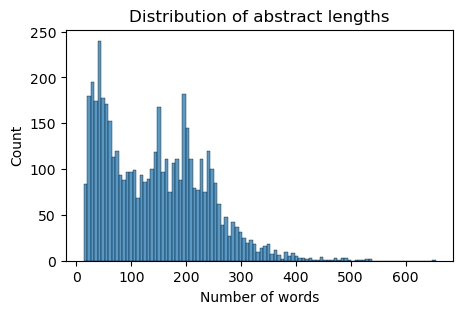

In [35]:
# get a picture of the lengths distribution of the abstracts
plot_length_distribution(baseline_val)

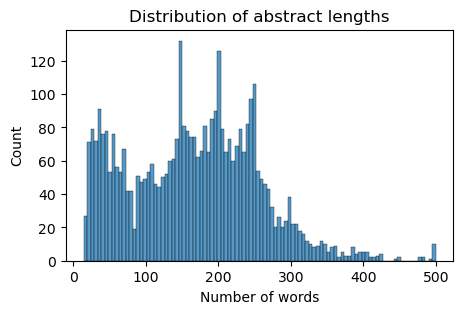

In [36]:
# abstracts with more than 800 tokens were truncated
plot_length_distribution(train_test_papers)

The first is a strangely bi- or multimodal distribution.  I see drops before 100, 150, 200 and 250 words.  
That has probably to do with the specific requirements posed by the individual journals to which they were submitted.  
However, this is going to be a problem when using the longer abstracts in the context of transformers: they often have 
an upper length limit of 512 **after their own tokenization** which, so it seems, can get very high (see notebook `transformers_feature_extraction.ipynb`)

## Split train/test
For now, I will work wth the original, non preprocessed abstracts because they are more suitable for CNNs, the 

In [37]:
data_selection = 'abstract' # could be done on lowercase, or title as well
x_train, x_test, y_train, y_test = train_test_split(train_test_papers[data_selection], 
                                                    train_test_papers['label'], 
                                                    test_size=0.3,
                                                    random_state=123)
x_train.head()

898     The utilization of technology, including robot...
1748    The control of poliomyelitis in Uganda dates b...
1361    The dinitrogen complex [(N2)Cu{Al(ORF)4}] (RF ...
1848    Traditional medicine and herbal medicine are r...
3862    Pesticides are detectable in most aquatic habi...
Name: abstract, dtype: object

In [38]:
x_val = baseline_val[data_selection]
y_val = baseline_val['label']

x_val_pos = curated_pesticide_abstracts[data_selection]
y_val_pos = curated_pesticide_abstracts['label']

### Implement CNN classifier

In [39]:
# number of classes
K = train_test_papers['label'].max() + 1
K

2

In [40]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE) # tokenizer from tensorflow.keras.preprocessing.text
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train) # returns a python list of lists (of numbers)
sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_val = tokenizer.texts_to_sequences(x_val)
sequences_val_pos = tokenizer.texts_to_sequences(x_val_pos)
print(f'train sequences: {len(sequences_train)}; test sequences: {len(sequences_test)}')

train sequences: 2741; test sequences: 1176


In [41]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 29121 unique tokens.


In [42]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (2741, 465)


In [43]:
# also pad the test sequences. Note that we use the same T as for the training data
# (this is important!)
data_test = pad_sequences(sequences_test, maxlen=T)
data_val = pad_sequences(sequences_val, maxlen=T)
data_val_pos = pad_sequences(sequences_val_pos, maxlen=T)

print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1176, 465)


In [44]:
# We get to choose embedding dimensionality
D = 50

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)                 # output is T x D
x = Conv1D(32, 3, activation='relu')(x)    # output is T^* x M

## SIMPLER PERFORMS MUCH BETTER THAN MORE COMPLEX MODELS
# x = MaxPooling1D(3)(x)
# x = Conv1D(64, 3, activation='relu')(x)    # output is T2 x M2
# x = MaxPooling1D(3)(x)  
# x = Conv1D(128, 3, activation='relu')(x)   # output is T3 x M3
x = GlobalMaxPooling1D()(x)                # output is M3
# OR: x = Flatten()(x)                     # instead of pool

x = Dense(K)(x)                            # binary case
# OR: x = Dens(K)(x)                       # general case

model_cnn = Model(i, x)

In [45]:

# these are the default values; but included for information value
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) 

# Compile and fit
model_cnn.compile(
	loss=SparseCategoricalCrossentropy(from_logits=True),
	optimizer=optm,
	metrics=['accuracy']
)

In [46]:
r = model_cnn.fit(
	data_train,
	y_train, #df_train['label'],
	epochs=15, # after 15 epochs, nothing much changes anymore (previously tested)
	validation_data=(data_test, y_test)#df_test['label'])
)

Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6371 - loss: 0.6205 - val_accuracy: 0.8835 - val_loss: 0.3450
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9165 - loss: 0.2686 - val_accuracy: 0.9609 - val_loss: 0.1343
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9697 - loss: 0.1001 - val_accuracy: 0.9779 - val_loss: 0.0676
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9955 - loss: 0.0389 - val_accuracy: 0.9830 - val_loss: 0.0467
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9954 - loss: 0.0226 - val_accuracy: 0.9881 - val_loss: 0.0370
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9974 - loss: 0.0117 - val_accuracy: 0.9889 - val_loss: 0.0323
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0064 - val_accuracy: 0.9889 - val_loss: 0.0303
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9872 - val_lo

In [47]:
# save the model
model_cnn.save('./pipeline/models/pesticide_model_cnn.keras')
# load the model
# from keras.models import load_model
# model = load_model('./models/pesticide_model.h5')

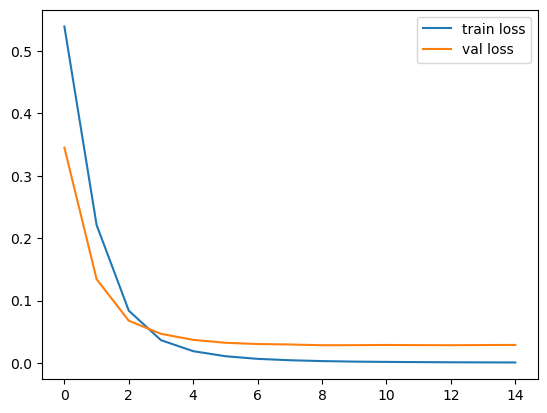

In [48]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

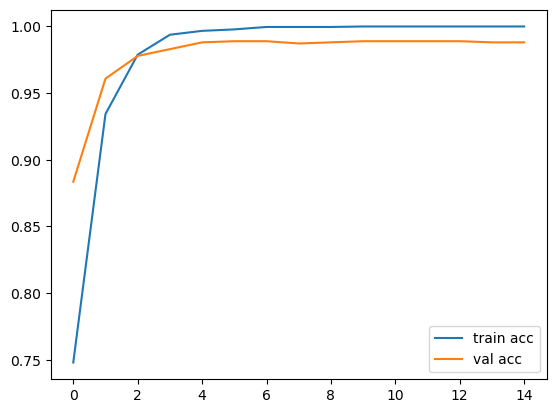

In [49]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [50]:
def evaluate(model):
    # The outputs are not probabilities but logits;
    # therefore, this check for bigger than zero (=positive class)
    # multiply by one to get numbers instead of booleans
    #P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
    P_train = (model.predict(data_train) > 0) * 1.0
    P_train = P_train[:, 1] # only positive class

    #P_test = ((model.predict(data_test > 0) * 1.0).flatten())
    P_test = (model.predict(data_test) > 0) * 1.0
    P_test = P_test[:, 1] # only positive
    cm_test = confusion_matrix(y_test, P_test, normalize='true')
    print(cm_test)
    utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.9905914  0.0094086 ]
 [0.01157407 0.98842593]]


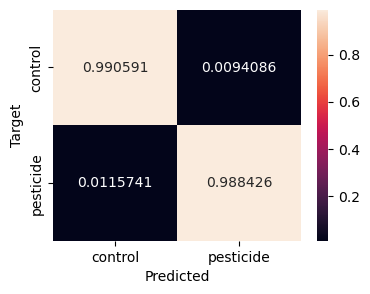

In [51]:
evaluate(model_cnn)

#### Evaluate on the curated dataset

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[0.        0.       ]
 [0.0397351 0.9602649]]


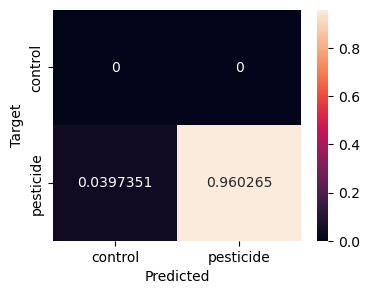

In [52]:
val_pos_pred = model_cnn.predict(data_val_pos)
P_val_pos = (val_pos_pred > 0) * 1.0
P_val_pos = P_val_pos[:, 1] # only positive
cm_val_pos = confusion_matrix(y_val_pos, P_val_pos, normalize='true')
print(cm_val_pos)
utils.plot_confusion_matrix(cm_val_pos, ['control', 'pesticide'])

#### Evaluate on the mostly negative baseline dataset

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.98794939 0.01205061]
 [0.14285714 0.85714286]]


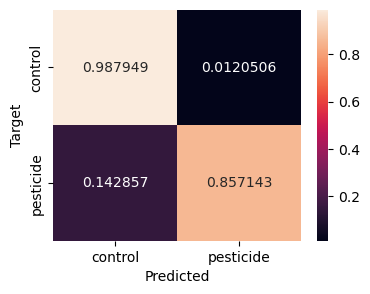

In [53]:
val_pred = model_cnn.predict(data_val)
P_val = (val_pred > 0) * 1.0
P_val = P_val[:, 1] # only positive
cm_val = confusion_matrix(y_val, P_val, normalize='true')
print(cm_val)
utils.plot_confusion_matrix(cm_val, ['control', 'pesticide'])

<Axes: ylabel='Count'>

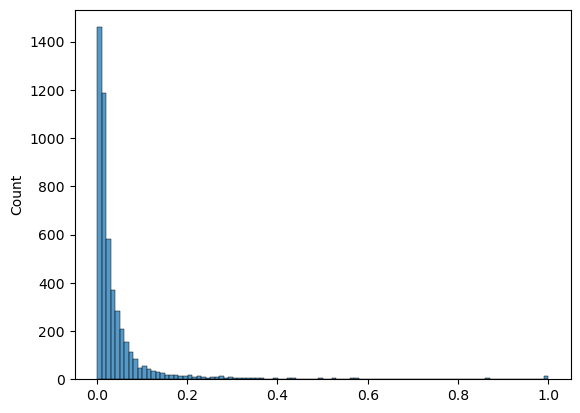

In [54]:

#prediction = tf.round(tf.nn.sigmoid(logit))
val_pred_prob = tf.nn.sigmoid(val_pred)
#val_pred_prob
sns.histplot(val_pred_prob[:, 1], bins=100)

# val_pred[:, 1] # logits of only the positive class
# sns.histplot(val_pred[:, 1], bins=100)
# get the probabilities



Remember this is a highly imbalanced dataset.
So now it is time to manually investigate the positives out of this set, or to create a human curated validation set.

In [55]:
# get the controls marked as pesticide papers
baseline_val['pred'] = P_val

# select where label==0 and pred==1
false_positives = baseline_val[(baseline_val['label'] == 0) & (baseline_val['pred'] == 1)]
# save the false positives
false_positives.to_csv('./data/false_positives.txt', sep='\t', index=False)

false_positives

,pmid,title,abstract,label,text_label,title_clean,abstract_clean,pred
108,40267515,"Feeling of an Eye When It Meets the Unseen ""Na...",Nanomedicine is increasingly being utilized in...,0,control,"feeling of an eye when it meets the unseen ""na...",nanomedicine is increasingly being utilized in...,1.0
147,37908211,A Case of Congenital Disorder of Glycosylation...,"We describe initial manifestations, approach t...",0,control,a case of congenital disorder of glycosylation...,"we describe initial manifestations, approach t...",1.0
155,39031838,Development and validation of a simultaneous q...,Much more attention has been paid to the conta...,0,control,development and validation of a simultaneous q...,much more attention has been paid to the conta...,1.0
192,37882291,Nitrogen supply alleviates seed yield reductio...,"Shading significantly affects rapeseed yield, ...",0,control,nitrogen supply alleviates seed yield reductio...,"shading significantly affects rapeseed yield, ...",1.0
198,39036134,Integrative Approach to Address Male Infertili...,"Factors, including exposure to substances like...",0,control,integrative approach to address male infertili...,"factors, including exposure to substances like...",1.0
310,40228058,Effect of aqueous washing on chloride reductio...,The presence of chloropropanols in edible oils...,0,control,effect of aqueous washing on chloride reductio...,the presence of chloropropanols in edible oils...,1.0
362,37308417,[Effects of adipokine chemerin on the improvem...,<b>Objective:</b> To investigate the effects o...,0,control,[effects of adipokine chemerin on the improvem...,<b>objective:</b> to investigate the effects o...,1.0
366,39036124,Osteoimmunological Principles Adapted to Achie...,Introduction Triggering the immune system via ...,0,control,osteoimmunological principles adapted to achie...,introduction triggering the immune system via ...,1.0
408,39041148,[Study on optimal harvesting period and ration...,To determine the optimal harvesting period and...,0,control,[study on optimal harvesting period and ration...,to determine the optimal harvesting period and...,1.0
481,40070537,Isolation and evaluation of growth-promoting e...,The slow growth rate of <i>Zanthoxylum dissitu...,0,control,isolation and evaluation of growth-promoting e...,the slow growth rate of <i>zanthoxylum dissitu...,1.0


These false positives were manually inspected in a cursory manner. The majority of these were really non-pesticide papers and should have been marked negative  

In [56]:
# get the false-negatives
false_negatives = baseline_val[(baseline_val['label'] == 1) & (baseline_val['pred'] == 0)]
# save the false negatives
false_negatives.to_csv('./data/false_negatives.txt', sep='\t', index=False)
false_negatives


,pmid,title,abstract,label,text_label,title_clean,abstract_clean,pred
2178,40160003,Harnessing CNC-Carrier Nanomaterials for Enhan...,Oomycetes are devastating plant pathogens caus...,1,pesticide,harnessing cnc-carrier nanomaterials for enhan...,oomycetes are devastating plant pathogens caus...,0.0
4419,40211589,"Design, Synthesis, and Anti-Oomycete and Antif...",Paeonol is the main active ingredient in the C...,1,pesticide,"design, synthesis, and anti-oomycete and antif...",paeonol is the main active ingredient in the c...,0.0
4451,40138468,Host Defense Peptide-Mimicking Poly(2-oxazolin...,Given the limited types of agricultural bacter...,1,pesticide,host defense peptide-mimicking poly(2-oxazolin...,given the limited types of agricultural bacter...,0.0


The false-negatives have also been inspected manually.  
5 of these can be considered "real" pesticide papers.
5 of these can be considered "loosely related" to pesticides papers

**Conclusion: we have by no means a viable classifier yet** 

### Try FNN model with single hidden layer

In [57]:
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study', 'result', 'method', 
                                          "sup", "/sup", "sub", "/sub"}) 
tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)

In [58]:
# x_train; y_train; x_test, y_test;
# x_val, y_val; x_val_pos, y_val_pos; 

x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
x_val_vec = vectorizer.transform(x_val)
x_val_pos_vec = vectorizer.transform(x_val_pos)
# Note the use of different functions for train and test data !

x_train_vec.shape # is a sparse matrix!

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2741, 2500)

In [59]:
# data must not be sparse matrix before passing into tensorflow
x_train_vec = x_train_vec.toarray()
x_test_vec = x_test_vec.toarray()
x_val_vec = x_val_vec.toarray()
x_val_pos_vec = x_val_pos_vec.toarray()
x_train_vec.shape

(2741, 2500)

In [60]:
# number of columns from input dimensions required to specify in the model
D = x_train_vec.shape[1]

# build model
i = Input(shape=(D,))
# Dense layer with D inputs and one output; no sigmoid here because included in loss
x = Dense(1)(i) 
model_fnn = Model(i, x)

In [61]:
model_fnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model_fnn.compile(
  loss=BinaryCrossentropy(from_logits=True), # different from regression
  optimizer=Adam(learning_rate=0.01), # much lower learning rate
  metrics=['accuracy']            # different from regression; will have two metrics: accuracy and loss
)

r = model_fnn.fit(
  x_train_vec, y_train,
  #validation data only with classification!
  validation_data=(x_test_vec, y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6275 - loss: 0.6446 - val_accuracy: 0.6327 - val_loss: 0.5112
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.4779 - val_accuracy: 0.7347 - val_loss: 0.4046
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7699 - loss: 0.3822 - val_accuracy: 0.8520 - val_loss: 0.3332
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 0.3152 - val_accuracy: 0.8937 - val_loss: 0.2849
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9035 - loss: 0.2693 - val_accuracy: 0.9192 - val_loss: 0.2498
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.2278 - val_accuracy: 0.9294 - val_loss: 0.2238
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9466 - loss: 0.2079 - val_accuracy: 0.9405 - val_loss: 0.2037
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.1840 - val_accuracy: 0.9464 - val_loss:

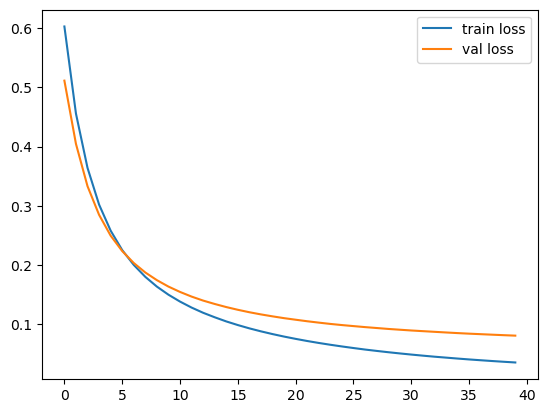

In [63]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

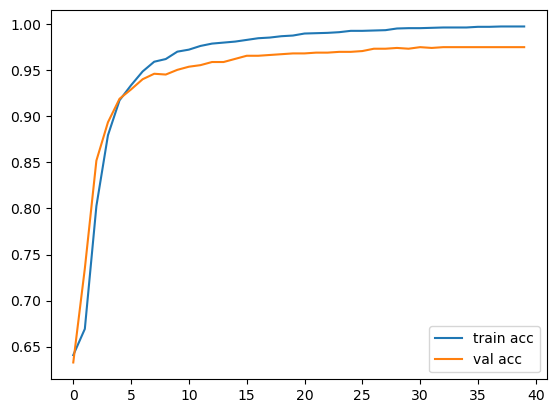

In [64]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [65]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
P_train = ((model_fnn.predict(x_train_vec) > 0) * 1.0).flatten()
P_test = ((model_fnn.predict(x_test_vec) > 0) * 1.0).flatten()
P_val = ((model_fnn.predict(x_val_vec) > 0) * 1.0).flatten()
P_val_pos = ((model_fnn.predict(x_val_pos_vec) > 0) * 1.0).flatten()

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


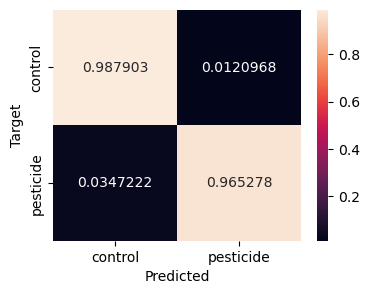

In [66]:
cm_train = confusion_matrix(y_test, P_test, normalize='true')
utils.plot_confusion_matrix(cm_train, ['control', 'pesticide'])

In [67]:
Pr_train = model_fnn.predict(x_train_vec)
Pr_test = model_fnn.predict(x_test_vec)
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
Train AUC: 0.9999988437033868
Test AUC: 0.9971655963759458


In [68]:
print("Train F1:", f1_score(y_train, P_train))
print("Test F1:", f1_score(y_test, P_test))

Train F1: 0.9994921279837481
Test F1: 0.972027972027972


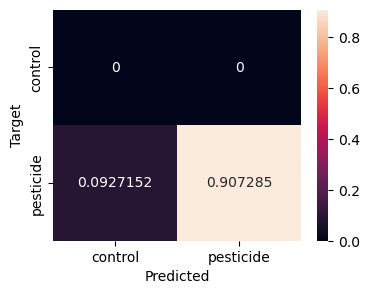

In [69]:
cm_val_pos = confusion_matrix(y_val_pos, P_val_pos, normalize='true')
utils.plot_confusion_matrix(cm_val_pos, ['control', 'pesticide'])

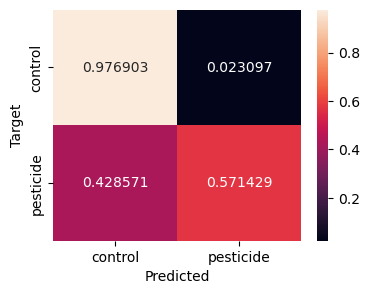

In [70]:
cm_val = confusion_matrix(y_val, P_val, normalize='true')
utils.plot_confusion_matrix(cm_val, ['control', 'pesticide'])

In [71]:
# store the weights
weights = model_fnn.layers[1].get_weights()[0]

word_index_map = vectorizer.vocabulary_ # word:index mapping

# print(len(word_index_map))
# print(len(weights))
weights


array([[ 1.9620546],
       [-1.195948 ],
       [-1.4289786],
       ...,
       [ 0.923122 ],
       [ 1.6170994],
       [ 1.635891 ]], dtype=float32)

In [72]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("terms in favor of pesticide:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))
#print(word_weight_tuples[:10])
print(f'weights above threshold {threshold}: {len(word_weight_tuples)}\n')
word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1]) # sort reverse by weight
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)


terms in favor of pesticide:

weights above threshold 2: 176

permethrin 3.4080524
fungicide 3.3466454
atrazine 3.3187585
herbicide 3.2533774
glyphosate 3.2219422
pesticide 3.221246
insecticide 3.2038732
chemical 3.159335
carbaryl 3.1328926
exposed 3.113367
exposure 3.1049652
imidacloprid 3.0932653
chlorpyrifos 3.0768943
pyrethroid 3.0016832
chloride 2.978776
five 2.9543166
untreated 2.928382
tested 2.9091072
environmental 2.897552
similar 2.861152


In [73]:
print("Terms in favor of control:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1]) # sort by weight
print(f'weights below threshold {threshold}: {len(word_weight_tuples)}\n')
for i in range(20):
  if i == len(word_weight_tuples):
    break
  word, weight = word_weight_tuples[i]
  print(word, weight)


Terms in favor of control:

weights below threshold 2: 121

stability -3.150783
additionally -2.9611037
aimed -2.9477863
notably -2.8389688
promising -2.775669
find -2.6672878
index -2.6326191
globally -2.6019936
aim -2.5984976
unclear -2.5896904
viral -2.584076
conductivity -2.572125
furthermore -2.456988
exhibit -2.4508138
explore -2.4491122
storage -2.4477098
interface -2.4355733
role -2.4311435
promote -2.4233882
crucial -2.4172852


## Explore Vector "landscape"
#### See other notebook (UMAP)

## Neighbour search (& clustering)

Using an TF-IDF vector of all PubMed abstracts is probably not yet feasible, so I will focus on a smaller subset of Pesticide-related papers first.  

